#Task 5: Attention-based Neural Machine Translation

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
path_to_zip = "/gdrive/My\ Drive/Colab\ Notebooks/IDL_Semester_Task_5/deu-eng/"
path_to_file = "deu.txt"

Mounted at /gdrive


In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [ ]:
# Converts the unicode file to ascii and retain german alphabets as is
# Reference:- https://stackoverflow.com/questions/44576486/how-to-remove-just-the-accents-but-not-umlauts-from-strings-in-python

def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      #if unicodedata.category(c) != 'Mn')
      if not unicodedata.name(c).endswith('ACCENT'))

def preprocess_sentence(w):
  w = unicode_to_ascii(w.strip())
  #print(w)

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", AND german alphabets)
  # Reference:- https://stackoverflow.com/questions/22017723/regex-for-umlaut   \u00c4\u00e4\u00d6\u00f6\u00dc\u00fc\u00df
  w = re.sub(r"^[^\u00c4\u00e4\u00d6\u00f6\u00dc\u00fc\u00dfa-zA-Z?.!,']+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
en_sentence = u"Mary's hubby is chubby."
de_sentence = u"Marias Ehemännchen ist mopsig."
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(de_sentence).encode('utf-8'))

<start> Mary's hubby is chubby . <end>
b'<start> Marias Ehema\xcc\x88nnchen ist mopsig . <end>'


In [ ]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, GERMAN]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[25000:num_examples]]
  return zip(*word_pairs)

In [ ]:
%cd /gdrive/My\ Drive/Colab\ Notebooks/IDL_Semester_Task_5/deu-eng/
! ls

/gdrive/My Drive/Colab Notebooks/IDL_Semester_Task_5/deu-eng
_about.txt  training_checkpoints_bahdanau  training_checkpoints_luong_general
deu.txt     training_checkpoints_dot


In [ ]:
en, de = create_dataset(path_to_file, None)
print(en[-1])
print(de[-1])

<start> Doubtless there exists in this world precisely the right woman for any given man to marry and vice versa; but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> Ohne Zweifel findet sich auf dieser Welt zu jedem Mann genau die richtige Ehefrau und umgekehrt; wenn man jedoch in Betracht zieht , dass ein Mensch nur Gelegenheit hat , mit ein paar hundert anderen bekannt zu sein , von denen ihm nur ein Dutzend oder weniger nahesteht , darunter höchstens ein oder zwei Freunde , dann erahnt man eingedenk der Millionen Einwohner dieser Welt leicht , dass seit Erschaffung ebenderselben wohl no

In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='', lower=False)
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)
  #print(inp_lang[1])
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
# Try experimenting with the size of that dataset
num_examples = 200000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
del en
del de

In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

140000 140000 35000 35000


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
  temp_sentence = "Ohne Wasser mussten die Blumen sterben."
  temp_sentence = preprocess_sentence(temp_sentence)
  temp_inputs = [inp_lang.word_index[i] for i in temp_sentence.split(' ')]
  temp_inputs = tf.keras.preprocessing.sequence.pad_sequences([temp_inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  #temp_inputs = tf.convert_to_tensor(temp_inputs)


  tar_sentence = "Without water the flowers had to die."
  tar_sentence = preprocess_sentence(tar_sentence)
  temp_outputs = [targ_lang.word_index[i] for i in tar_sentence.split(' ')]
  temp_outputs = tf.keras.preprocessing.sequence.pad_sequences([temp_outputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
 # temp_outputs = tf.convert_to_tensor(temp_outputs)

In [ ]:
temp_inputs

array([[   1,  898,  316, 2039,   16,  642, 1102,    3,    2,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0]], dtype=int32)

In [ ]:
temp_outputs

array([[   1, 1886,  317,    9,  656,   71,    5,  796,    3,    2,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0]], dtype=int32)

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, temp_inputs[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, temp_outputs[0])

Input Language; index to word mapping
1 ----> <start>
898 ----> Ohne
316 ----> Wasser
2039 ----> mussten
16 ----> die
642 ----> Blumen
1102 ----> sterben
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
1886 ----> Without
317 ----> water
9 ----> the
656 ----> flowers
71 ----> had
5 ----> to
796 ----> die
3 ----> .
2 ----> <end>


In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
24 ----> Das
225 ----> musst
12 ----> du
144 ----> sehen
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
27 ----> You
17 ----> have
5 ----> to
93 ----> see
24 ----> this
3 ----> .
2 ----> <end>


In [ ]:
BUFFER_SIZE = len(input_tensor_train)//4
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 24]), TensorShape([64, 19]))

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 24, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


## Bahdanau Attention (Concat Attention)

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 24, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 15307)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = './training_checkpoints_bahdanau'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.2317
Epoch 1 Batch 100 Loss 2.4494
Epoch 1 Batch 200 Loss 2.1759
Epoch 1 Batch 300 Loss 1.9603
Epoch 1 Batch 400 Loss 1.8501
Epoch 1 Batch 500 Loss 1.7423
Epoch 1 Batch 600 Loss 1.6586
Epoch 1 Batch 700 Loss 1.4759
Epoch 1 Batch 800 Loss 1.5027
Epoch 1 Batch 900 Loss 1.4602
Epoch 1 Batch 1000 Loss 1.4109
Epoch 1 Batch 1100 Loss 1.2679
Epoch 1 Batch 1200 Loss 1.1311
Epoch 1 Batch 1300 Loss 1.2684
Epoch 1 Batch 1400 Loss 1.2257
Epoch 1 Batch 1500 Loss 1.1819
Epoch 1 Batch 1600 Loss 1.1300
Epoch 1 Batch 1700 Loss 0.9991
Epoch 1 Batch 1800 Loss 1.0233
Epoch 1 Loss 1.5278
Time taken for 1 epoch 347.5363585948944 sec

Epoch 2 Batch 0 Loss 1.0590
Epoch 2 Batch 100 Loss 0.8965
Epoch 2 Batch 200 Loss 0.9178
Epoch 2 Batch 300 Loss 0.9082
Epoch 2 Batch 400 Loss 0.8557
Epoch 2 Batch 500 Loss 0.7749
Epoch 2 Batch 600 Loss 0.7030
Epoch 2 Batch 700 Loss 0.7912
Epoch 2 Batch 800 Loss 0.8338
Epoch 2 Batch 900 Loss 0.7330
Epoch 2 Batch 1000 Loss 0.6455
Epoch 2 Batch 1100 Loss 0.71

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  print(sentence)
  sentence = preprocess_sentence(sentence)
  print(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis', clim=[0,1])

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Die Insel ist mit dem Boot leicht zu erreichen.
<start> Die Insel ist mit dem Boot leicht zu erreichen . <end>
Input: <start> Die Insel ist mit dem Boot leicht zu erreichen . <end>
Predicted translation: The island is easy to get to the boat . <end> 


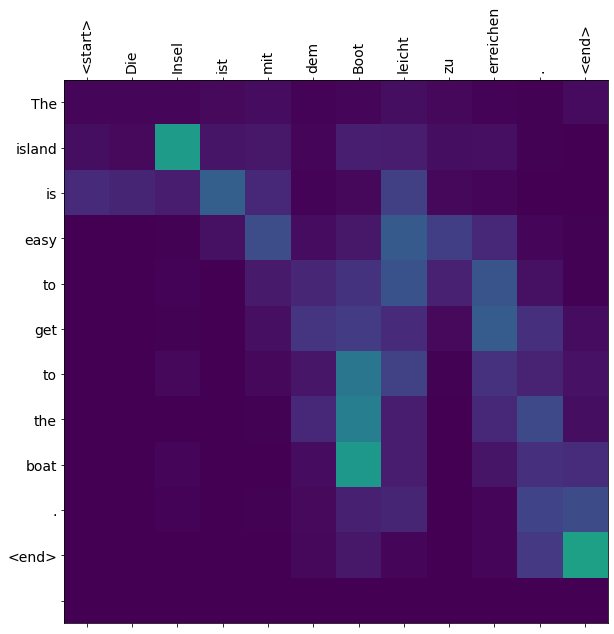

In [ ]:
translate(u'Die Insel ist mit dem Boot leicht zu erreichen.')

Der Mann verliebte sich auf den ersten Blick.
<start> Der Mann verliebte sich auf den ersten Blick . <end>
Input: <start> Der Mann verliebte sich auf den ersten Blick . <end>
Predicted translation: The man fell in love at first sight . <end> 


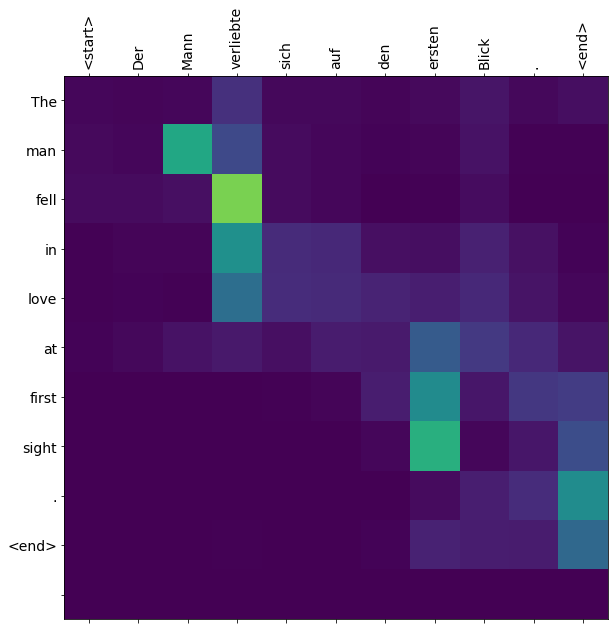

In [ ]:
translate(u'Der Mann verliebte sich auf den ersten Blick.')

Die Regel gilt nur für Ausländer.
<start> Die Regel gilt nur für Ausländer . <end>
Input: <start> Die Regel gilt nur für Ausländer . <end>
Predicted translation: The rule only applies to foreigners . <end> 


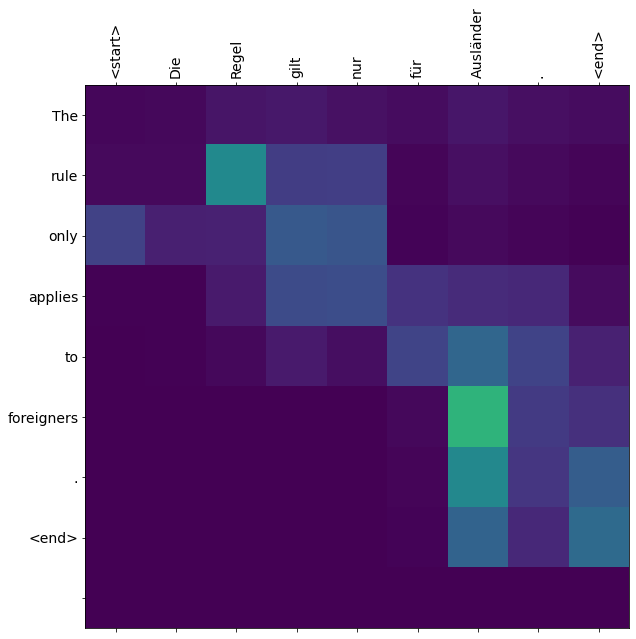

In [ ]:
translate(u'Die Regel gilt nur für Ausländer.')

Wir werden wahrscheinlich vor Einbruch der Dunkelheit dort ankommen.
<start> Wir werden wahrscheinlich vor Einbruch der Dunkelheit dort ankommen . <end>
Input: <start> Wir werden wahrscheinlich vor Einbruch der Dunkelheit dort ankommen . <end>
Predicted translation: We are likely to get there before dark . <end> 


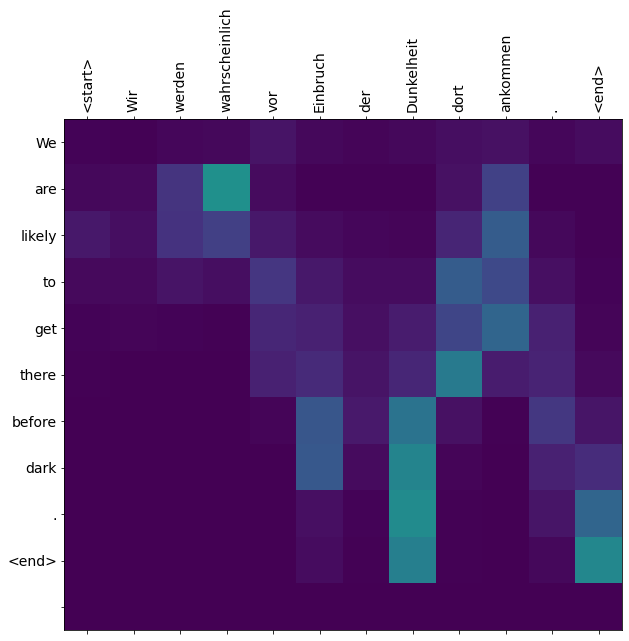

In [ ]:
translate(u'Wir werden wahrscheinlich vor Einbruch der Dunkelheit dort ankommen.')

Es besteht kein Zweifel an seiner Ehrlichkeit.
<start> Es besteht kein Zweifel an seiner Ehrlichkeit . <end>
Input: <start> Es besteht kein Zweifel an seiner Ehrlichkeit . <end>
Predicted translation: There is no doubt of his honesty . <end> 


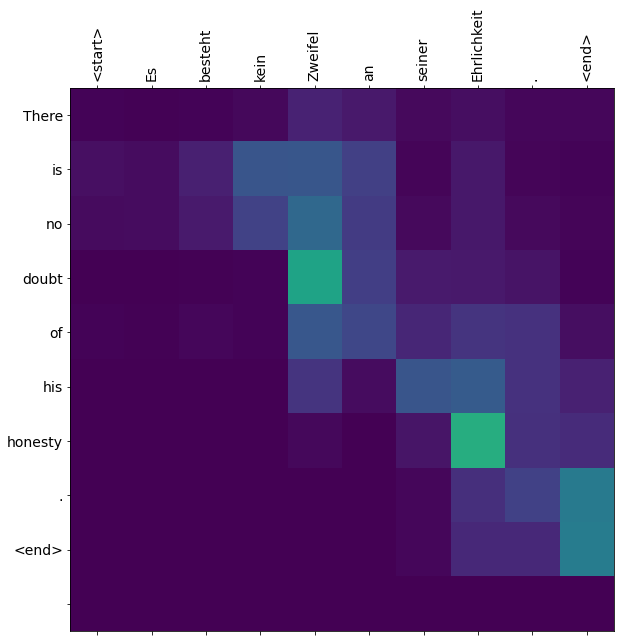

In [ ]:
translate(u'Es besteht kein Zweifel an seiner Ehrlichkeit.')

## Luong Multiplicative Style Attention (General Attention)

In [ ]:
class LuongMultiplicativeAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(LuongMultiplicativeAttention, self).__init__()
    self.Wa = tf.keras.layers.Dense(units)

  def call(self, query, values):
    # Dot score: h_t (dot) Wa (dot) h_s
    query_with_time_axis = tf.expand_dims(query, 1)
    temp = self.Wa(values)

    score = tf.matmul(temp, query_with_time_axis, transpose_b=True)
    #score = query_with_time_axis * temp

    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    
    return context_vector, attention_weights

In [ ]:
attention_layer = LuongMultiplicativeAttention(1024)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 24, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = LuongMultiplicativeAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 15931)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir1 = './training_checkpoints_luong_general'
checkpoint_prefix1 = os.path.join(checkpoint_dir1, "ckpt")
checkpoint1 = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 200 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint1.save(file_prefix = checkpoint_prefix1)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.0025
Epoch 1 Batch 200 Loss 2.0951
Epoch 1 Batch 400 Loss 1.8986
Epoch 1 Batch 600 Loss 1.7786
Epoch 1 Batch 800 Loss 1.7253
Epoch 1 Batch 1000 Loss 1.6311
Epoch 1 Batch 1200 Loss 1.6683
Epoch 1 Batch 1400 Loss 1.4937
Epoch 1 Batch 1600 Loss 1.5509
Epoch 1 Batch 1800 Loss 1.5097
Epoch 1 Batch 2000 Loss 1.4627
Epoch 1 Loss 1.7241
Time taken for 1 epoch 995.236946105957 sec

Epoch 2 Batch 0 Loss 1.4743
Epoch 2 Batch 200 Loss 1.3927
Epoch 2 Batch 400 Loss 1.3627
Epoch 2 Batch 600 Loss 1.3352
Epoch 2 Batch 800 Loss 1.3780
Epoch 2 Batch 1000 Loss 1.3574
Epoch 2 Batch 1200 Loss 1.2461
Epoch 2 Batch 1400 Loss 1.3862
Epoch 2 Batch 1600 Loss 1.3591
Epoch 2 Batch 1800 Loss 1.2527
Epoch 2 Batch 2000 Loss 1.2008
Epoch 2 Loss 1.3425
Time taken for 1 epoch 967.4695611000061 sec

Epoch 3 Batch 0 Loss 1.2592
Epoch 3 Batch 200 Loss 1.3337
Epoch 3 Batch 400 Loss 1.1209
Epoch 3 Batch 600 Loss 1.2021
Epoch 3 Batch 800 Loss 1.1522
Epoch 3 Batch 1000 Loss 1.2128
Epoch 3 Batch 1200 Los

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  print(sentence)
  sentence = preprocess_sentence(sentence)
  print(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis', clim=[0,1])

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint1.restore(tf.train.latest_checkpoint(checkpoint_dir1))

Die Insel ist mit dem Boot leicht zu erreichen.
<start> Die Insel ist mit dem Boot leicht zu erreichen . <end>
Input: <start> Die Insel ist mit dem Boot leicht zu erreichen . <end>
Predicted translation: The island is easy to reach by boat . <end> 


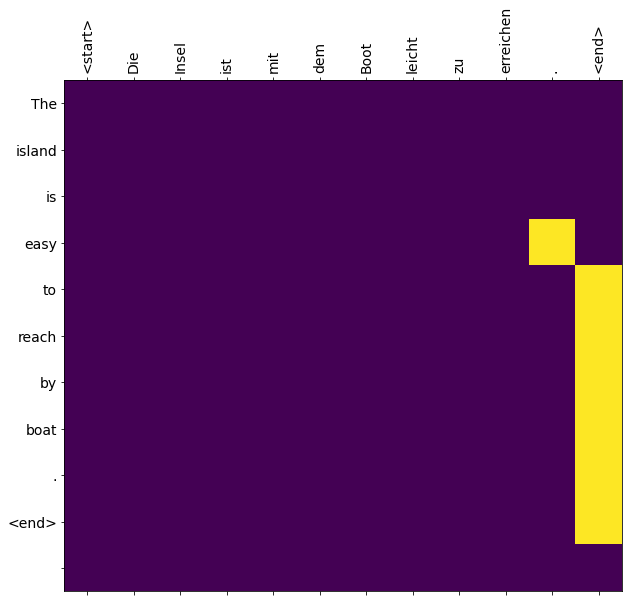

In [ ]:
translate(u'Die Insel ist mit dem Boot leicht zu erreichen.')

Der Mann verliebte sich auf den ersten Blick.
<start> Der Mann verliebte sich auf den ersten Blick . <end>
Input: <start> Der Mann verliebte sich auf den ersten Blick . <end>
Predicted translation: The man fell in love at first sight . <end> 


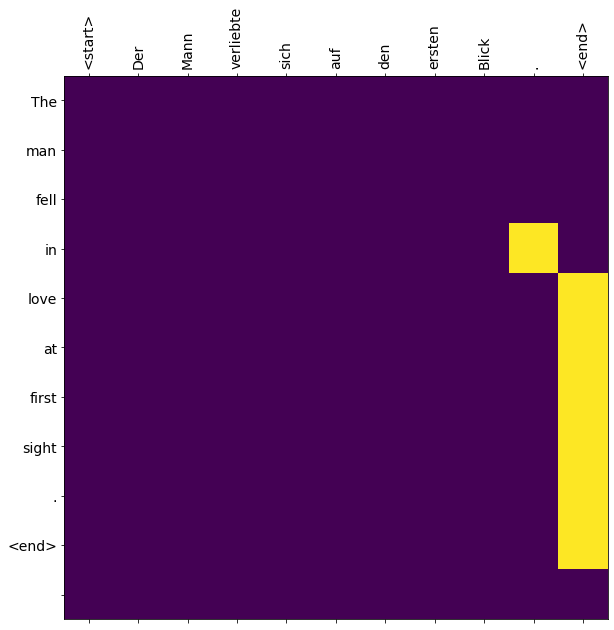

In [ ]:
translate(u'Der Mann verliebte sich auf den ersten Blick.')

Die Regel gilt nur für Ausländer.
<start> Die Regel gilt nur für Ausländer . <end>
Input: <start> Die Regel gilt nur für Ausländer . <end>
Predicted translation: The rule is only doctors . <end> 


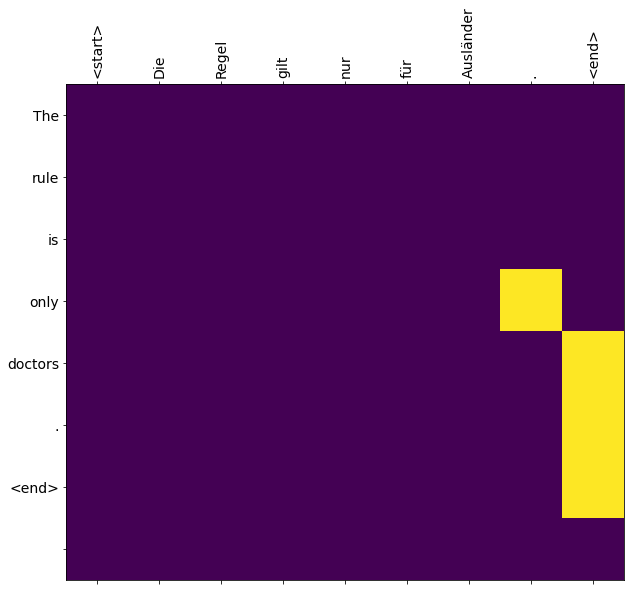

In [ ]:
translate(u'Die Regel gilt nur für Ausländer.')

Wir werden wahrscheinlich vor Einbruch der Dunkelheit dort ankommen.
<start> Wir werden wahrscheinlich vor Einbruch der Dunkelheit dort ankommen . <end>
Input: <start> Wir werden wahrscheinlich vor Einbruch der Dunkelheit dort ankommen . <end>
Predicted translation: We will probably get there before dark . <end> 


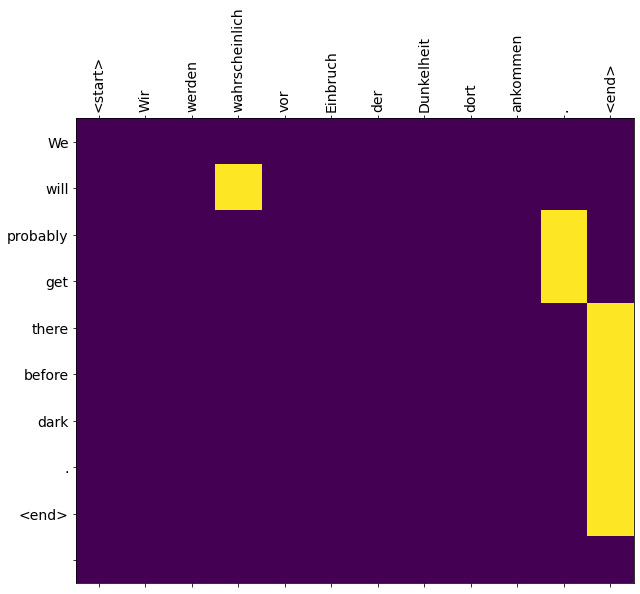

In [ ]:
translate(u'Wir werden wahrscheinlich vor Einbruch der Dunkelheit dort ankommen.')

Was ist das für ein Lied, das da gerade im Radio läuft?
<start> Was ist das für ein Lied , das da gerade im Radio läuft ? <end>
Input: <start> Was ist das für ein Lied , das da gerade im Radio läuft ? <end>
Predicted translation: What's that song on the radio ? <end> 


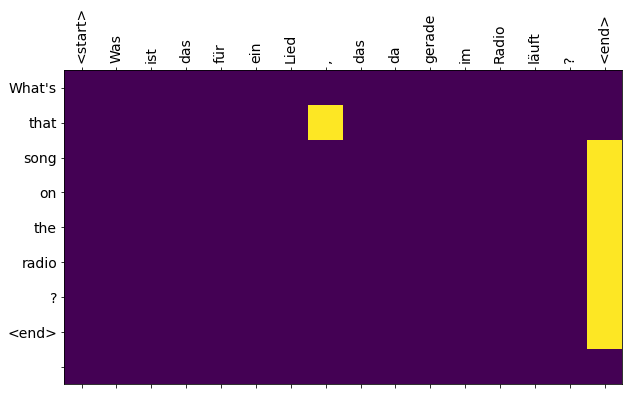

In [ ]:
translate(u'Was ist das für ein Lied, das da gerade im Radio läuft?')

## Dot Product Attention 

In [ ]:
class DotProductAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(DotProductAttention, self).__init__()
    
  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)

    score =  tf.matmul(values, query_with_time_axis, transpose_b=True)

    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = DotProductAttention(1024)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 24, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = DotProductAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 15931)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir2 = './training_checkpoints_dot'
checkpoint_prefix2 = os.path.join(checkpoint_dir2, "ckpt")
checkpoint2 = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 200 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint2.save(file_prefix = checkpoint_prefix2)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.2055
Epoch 1 Batch 200 Loss 1.3585
Epoch 1 Batch 400 Loss 1.0496
Epoch 1 Batch 600 Loss 0.8203
Epoch 1 Batch 800 Loss 0.8692
Epoch 1 Batch 1000 Loss 0.8113
Epoch 1 Batch 1200 Loss 0.6458
Epoch 1 Batch 1400 Loss 0.7067
Epoch 1 Batch 1600 Loss 0.6653
Epoch 1 Batch 1800 Loss 0.7434
Epoch 1 Batch 2000 Loss 0.6207
Epoch 1 Loss 0.9333
Time taken for 1 epoch 498.63513803482056 sec

Epoch 2 Batch 0 Loss 0.5392
Epoch 2 Batch 200 Loss 0.5021
Epoch 2 Batch 400 Loss 0.4881
Epoch 2 Batch 600 Loss 0.5210
Epoch 2 Batch 800 Loss 0.5164
Epoch 2 Batch 1000 Loss 0.4476
Epoch 2 Batch 1200 Loss 0.5491
Epoch 2 Batch 1400 Loss 0.2751
Epoch 2 Batch 1600 Loss 0.4475
Epoch 2 Batch 1800 Loss 0.4660
Epoch 2 Batch 2000 Loss 0.4499
Epoch 2 Loss 0.4804
Time taken for 1 epoch 477.91671800613403 sec

Epoch 3 Batch 0 Loss 0.3791
Epoch 3 Batch 200 Loss 0.3142
Epoch 3 Batch 400 Loss 0.3065
Epoch 3 Batch 600 Loss 0.2511
Epoch 3 Batch 800 Loss 0.2676
Epoch 3 Batch 1000 Loss 0.3326
Epoch 3 Batch 1200 

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  print(sentence)
  sentence = preprocess_sentence(sentence)
  print(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis', clim=[0,1])

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint2.restore(tf.train.latest_checkpoint(checkpoint_dir2))

Die Insel ist mit dem Boot leicht zu erreichen.
<start> Die Insel ist mit dem Boot leicht zu erreichen . <end>
Input: <start> Die Insel ist mit dem Boot leicht zu erreichen . <end>
Predicted translation: The island is easy to reach by the island . <end> 


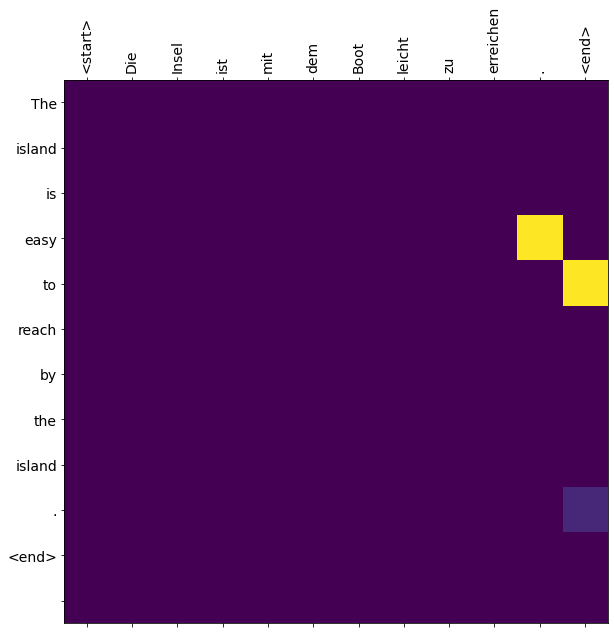

In [ ]:
translate(u'Die Insel ist mit dem Boot leicht zu erreichen.')

Der Mann verliebte sich auf den ersten Blick.
<start> Der Mann verliebte sich auf den ersten Blick . <end>
Input: <start> Der Mann verliebte sich auf den ersten Blick . <end>
Predicted translation: The man fell in love . <end> 


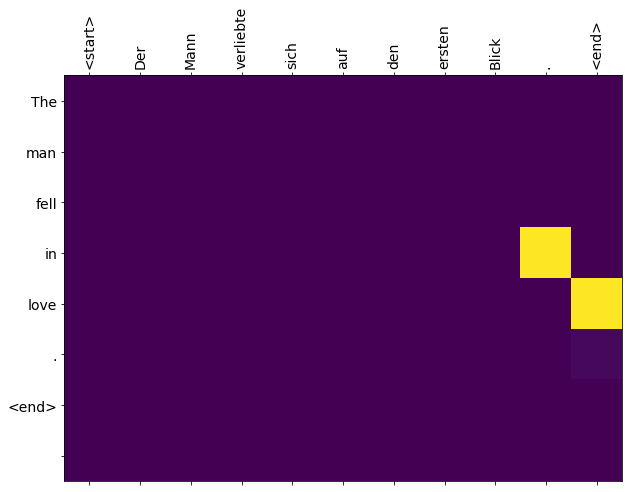

In [ ]:
translate(u'Der Mann verliebte sich auf den ersten Blick.')

Die Regel gilt nur für Ausländer.
<start> Die Regel gilt nur für Ausländer . <end>
Input: <start> Die Regel gilt nur für Ausländer . <end>
Predicted translation: The rule only applies to foreigners . <end> 


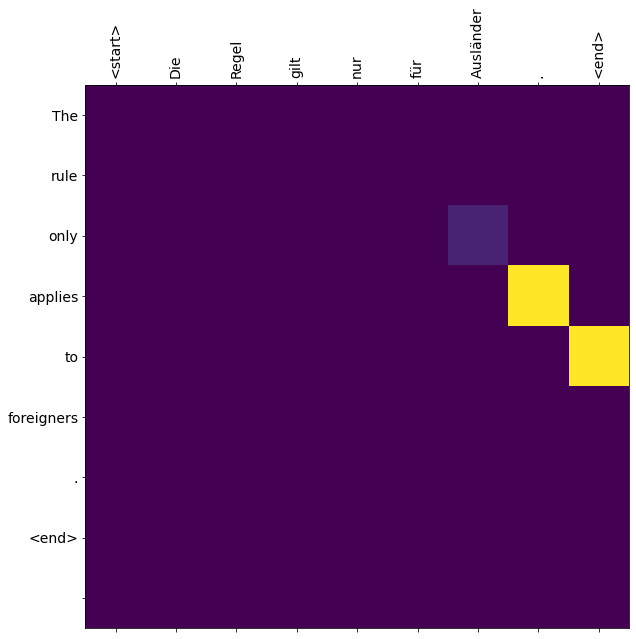

In [ ]:
translate(u'Die Regel gilt nur für Ausländer.')

Wir werden wahrscheinlich vor Einbruch der Dunkelheit dort ankommen.
<start> Wir werden wahrscheinlich vor Einbruch der Dunkelheit dort ankommen . <end>
Input: <start> Wir werden wahrscheinlich vor Einbruch der Dunkelheit dort ankommen . <end>
Predicted translation: We'll probably get there before going to get there before going to get there before going to get there 


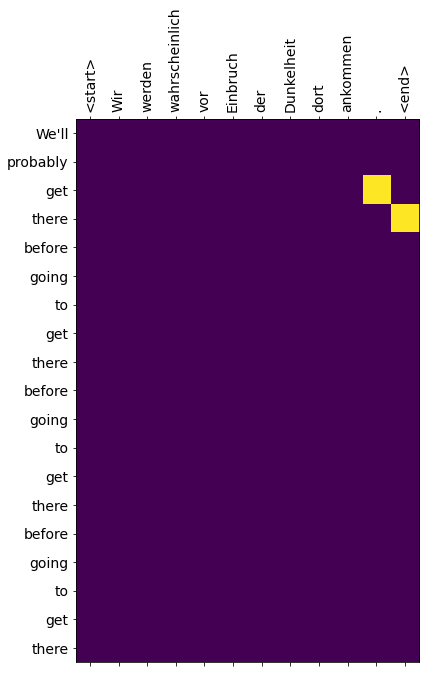

In [ ]:
translate(u'Wir werden wahrscheinlich vor Einbruch der Dunkelheit dort ankommen.')

Es besteht kein Zweifel an seiner Ehrlichkeit.
<start> Es besteht kein Zweifel an seiner Ehrlichkeit . <end>
Input: <start> Es besteht kein Zweifel an seiner Ehrlichkeit . <end>
Predicted translation: There is no doubt about his honesty . <end> 


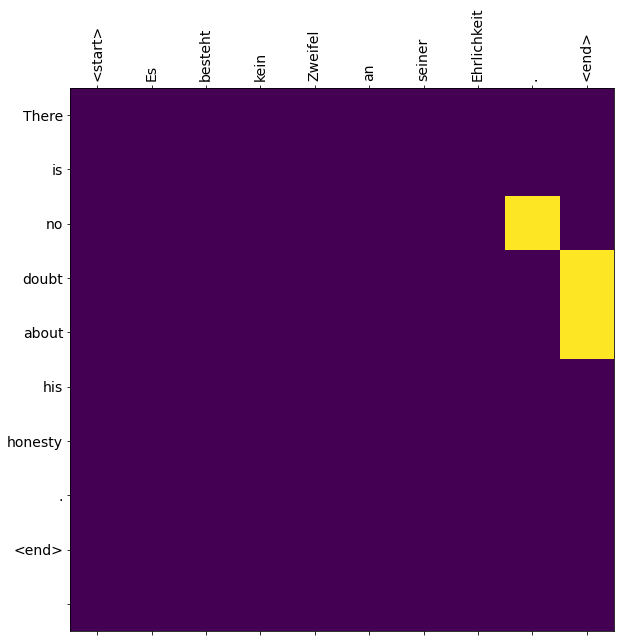

In [ ]:
translate(u'Es besteht kein Zweifel an seiner Ehrlichkeit.')

### Assignment Questions

- Which parts of the sentence are used as a token? Each character, each word, or are some words split up?  
Answer: Each word is used as a token. No words are split up during the formation of tokens. During pre-processing, all special characters except ".", "?", "!", "," are removed. All alphabets are retained. The pre-processing also takes into consideration the extra german alphabets.
<br>
<br>
- Do the same tokens in different language have the same ID?
e.g. Would the same token index map to the German word die and to the English word die?  
Answer: The tokens that are same in both the languages, do not have the same ID. As per the example given below, the token "die" has different IDs.<br>
<pre>
    Input Language; index to word mapping
    1 ----> &lt;start&gt;
    898 ----> Ohne
    316 ----> Wasser
    2039 ----> mussten
    16 ----> die
    642 ----> Blumen
    1102 ----> sterben
    3 ----> .
    2 ----> &lt;end&gt;
    
    Target Language; index to word mapping
    1 ----> &lt;start&gt;
    1886 ----> Without
    317 ----> water
    9 ----> the
    656 ----> flowers
    71 ----> had
    5 ----> to
    796 ----> die
    3 ----> .
    2 ----> &lt;end&gt;
</pre>
<br>
<br>
- What is the relation between the encoder output and the encoder hidden state which is used to initialize the decoder hidden state?
(for the architecture used in the tutorial)  
Answer:  The model reads the input sequence one at a time, and builds the hidden state for each input. However, the output of this model is only generated when the input sequence is completely processed, thus making the model asynchronous. This output is generated by applying a transformation on the last hidden state, which now contains all the information about the input sequence contents. The output will then be compared with the desired output y, in order to generate the loss value. The output is not a sequence anymore, but is a single value in vector format.
<br>
<br>
- Is the decoder attending to all previous positions, including the previous decoder predictions?  
Answer: The decoder has input from output of previous timestep, usually with output-to-hidden connections. The decoder takes into consideration the previous predictions, while computing for the current timestep.
<br>
<br>
- Does the Encoder output change in different decoding steps?  
Answer: During decoding process, if the output is not as expected, then by backpropagation, gradients can travel upto the encoder that contributed to the information that was used to make the prediction at that time. Thus the encoder output may change for different decoding steps.
<br>
<br>
- Does the context vector change in different decoding steps?  
Answer: Yes, the context vector is dynamic and changes for each decoding step. The context vector is the aggregated attention of the weighted sum of the encoder hidden states. During the decoding steps, it is possible to have updated attention weights, which in turn lead to an updated context vector.
<br>
<br>
- The decoder uses teacher forcing. Does this mean the time steps can be computed in parallel?  
Answer: In teacher forcing, the expected output is concatenated with the actual output, and passed to the next timestep. This still needs the sequential input from the previous timestep, and therefore the computation cannot be parallelized. RNNs can only be parallelized if all the connections are ground-truth to hidden connections.
<br>
<br>
- Why is a mask applied to the loss function?  
The samples provided as input are not of the same length. We pad the input before the training so as to make the input of a standard length. Masking is a way to tell sequence-processing layers that certain timesteps in an input are missing, and thus should be skipped when processing the data. 